In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = engine.execute("Select max(date) FROM measurement").fetchall()
#last_date
# Found last date was '2017-08-23'

#Alternate:
one_yr_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"The date one year ago was {one_yr_ago}")


The date one year ago was 2016-08-23


In [51]:
# Perform a query to retrieve the data and precipitation scores
precip_data = engine.execute("SELECT date, prcp FROM measurement WHERE date BETWEEN '2016-08-23' AND '2017-08-23'").fetchall()

# Using the classes to do it
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data, columns=['date', 'precip'])
#precip_df.set_index('date', inplace=True)
#precip_df.head(10)

# Sort the dataframe by date
precip_df['date'] = pd.to_datetime(precip_df.date)
precip_df.sort_values(by='date')
precip_df.set_index('date', inplace=True)
precip_df

,precip
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


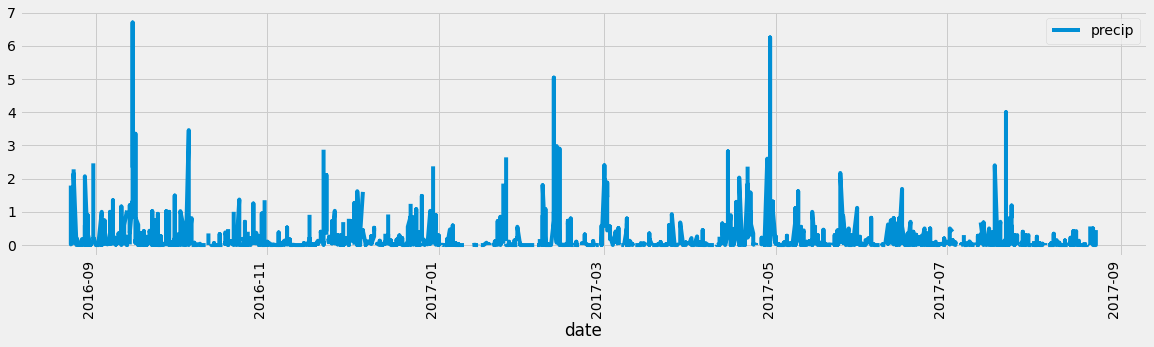

In [52]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind='line', figsize=(18,5))
plt.xticks(rotation=90)
plt.show()

In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_summ_stats = precip_df.agg({'precip':['mean','median','var','std','sem','min','max']})
precip_summ_stats

,precip
mean,0.177279
median,0.020000
var,0.212696
std,0.461190
sem,0.010259
min,0.000000
max,6.700000


In [54]:
# Design a query to show how many stations are available in this dataset?
unique_stations = engine.execute("SELECT station FROM station").fetchall()
unique_stations

# Alternate
unique_stations = session.query(Station.station).all()
unique_stations


[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_by_station = engine.execute('SELECT COUNT(station) AS "Number of entries per station", station FROM measurement GROUP BY station ORDER BY COUNT(station) DESC;').fetchall()
count_by_station

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [56]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# min_temp = engine.execute("SELECT MIN(tobs) FROM measurement WHERE station == 'USC00519281'").fetchall()
# max_temp = engine.execute("SELECT MAX(tobs) FROM measurement WHERE station == 'USC00519281'").fetchall()
# avg_temp = engine.execute("SELECT AVG(tobs) FROM measurement WHERE station == 'USC00519281'").fetchall()
# min_temp, max_temp, avg_temp

# Alternate:
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

usc00519281 = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
usc00519281


[(54.0, 85.0, 71.66378066378067)]

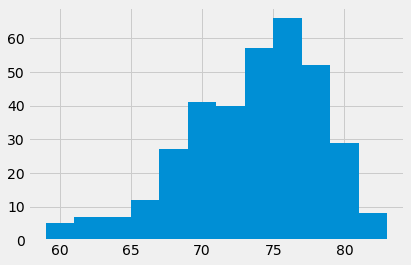

In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# usc00519281_df = engine.execute("SELECT date, prcp FROM measurement WHERE station == 'USC00519281' AND WHERE date BETWEEN '2016-08-23' AND '2017-08-23';").fetchall()
# usc00519281_df

date = dt.datetime(2016, 8, 23)

results = session.query(Measurement.tobs).filter(Measurement.date > date).filter(Measurement.station == 'USC00519281').all()

station_temps = list(np.ravel(results))

plt.hist(station_temps, bins=12)
plt.show()

## Bonus Challenge Assignment

In [57]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
